### Creating a Machine Learning Model using Pytorch and CV2 to predict Brazilian coin images 

This project is part of my journey to learn more about PyTorch, a powerful open-source machine learning library, and OpenCV (cv2), a library of programming functions mainly aimed at real-time computer vision. By building a model to predict Brazilian coin denominations from images, I aim to gain hands-on experience and deepen my understanding of how to use PyTorch and cv2 for real-world machine learning tasks.

In this notebook, I will be using the br-coins dataset to create a Convolutional Neural Network (CNN) model for image classification. The goal is to accurately predict the denomination of Brazilian coins based on images. Additionally, I will be using cv2 to identify circles in the images, which represent the coins.

The steps we will follow are:

*  **Data Preprocessing**: We will use the OpenCV library (cv2) to preprocess the images. This includes identifying circles (coins) in the images and resizing the images to a uniform size.
*  **Model Building**: We will use PyTorch to build our CNN. The model will consist of several convolutional layers for feature extraction, followed by fully connected layers for classification.
*  **Training**: We will train our model on the training set using a suitable loss function and optimizer. We will also use a validation set to tune the hyperparameters and prevent overfitting.
*  **Evaluation**: We will evaluate the performance of our model on the test set. We will use metrics such as accuracy, precision, recall, and F1 score to measure the performance of our model.
*  **Prediction**: Finally, we will use our trained model to predict the denomination of Brazilian coins from images.

By the end of this project, I hope to have a working model and a better understanding of how to use PyTorch and cv2 for image classification tasks.


### Criando um Modelo de Machine Learning usando Pytorch e CV2 para prever imagens de moedas brasileiras

Este projeto faz parte da minha jornada para aprender mais sobre PyTorch, uma poderosa biblioteca de aprendizado de máquina de código aberto, e OpenCV (cv2), uma biblioteca de funções de programação voltada principalmente para visão computacional em tempo real. Ao construir um modelo para prever as denominações de moedas brasileiras a partir de imagens, pretendo ganhar experiência prática e aprofundar minha compreensão de como usar o PyTorch e o cv2 para tarefas de aprendizado de máquina do mundo real.

Neste notebook, estarei usando o conjunto de dados br-coins para criar um modelo de Rede Neural Convolucional (CNN) para classificação de imagens. O objetivo é prever com precisão a denominação das moedas brasileiras com base nas imagens. Além disso, estarei usando o cv2 para identificar círculos nas imagens, que representam as moedas.

As etapas que seguiremos são:

*  **Pré-processamento de Dados**: Usaremos a biblioteca OpenCV (cv2) para pré-processar as imagens. Isso inclui identificar círculos (moedas) nas imagens e redimensionar as imagens para um tamanho uniforme.
*  **Construção do Modelo**: Usaremos o PyTorch para construir nossa CNN. O modelo consistirá em várias camadas convolucionais para extração de características, seguidas por camadas totalmente conectadas para classificação.
*  **Treinamento**: Treinaremos nosso modelo no conjunto de treinamento usando uma função de perda adequada e um otimizador. Também usaremos um conjunto de validação para ajustar os hiperparâmetros e prevenir o sobreajuste.
*  **Avaliação**: Avaliaremos o desempenho do nosso modelo no conjunto de testes. Usaremos métricas como acurácia, precisão, recall e pontuação F1 para medir o desempenho do nosso modelo.
*  **Predição**: Finalmente, usaremos nosso modelo treinado para prever a denominação das moedas brasileiras a partir de imagens.

Ao final deste projeto, espero ter um modelo funcional e uma melhor compreensão de como usar o PyTorch e o cv2 para tarefas de classificação de imagens. Vamos começar!


In [2]:
import os 
import torch
import torch.nn as nn 
import torch.nn.functional as F
import tarfile
import numpy as np 
import pandas as pd 
from torchvision import transforms
from PIL import Image
import torchvision
from torchvision.transforms import v2
import torch.utils.data

            
! pip install -q split-folders


#### Importing the necessary libraries and creating the function movefiles to move the data from one folder to another (Using shutil.copy because the dataset im using does not allow shutil.move)


In [3]:
import shutil
def movefiles(source, destination):
    allfiles = os.listdir(source)
    for f in allfiles:
        src_path = os.path.join(source, f)
        dst_path = os.path.join(destination, f)
        shutil.copy(src_path, dst_path)
        
try:
    os.mkdir(r"/kaggle/working/data")
except:
    print('already exists')
    
destination = r"/kaggle/working/data"
movefiles(r"/kaggle/input/br-coins/classification_dataset/all", destination)

#### Creating an unique folder for each image based on its label

In [4]:
os.mkdir(r"/kaggle/working/cinco")
os.mkdir(r"/kaggle/working/dez")
os.mkdir(r"/kaggle/working/vinte")
os.mkdir(r"/kaggle/working/cinquenta")
os.mkdir(r"/kaggle/working/umreal")
cinco = r"/kaggle/working/cinco"
des = r"/kaggle/working/dez"
vinte = r"/kaggle/working/vinte"
cinquenta = r"/kaggle/working/cinquenta"
um = r"/kaggle/working/umreal"

#### Moving the data to the right folder using the split function because the images are always in the same format: "label_xxxxxxx.jpg"


In [5]:
data = os.listdir(destination)
for f in data:
    count = 0
    #temp = []
    s = f.split('_')[0]
    #s = "".join(str(elem) for elem in temp)
    src = os.path.join(destination, f)
    if(s == "5"):
        shutil.move(src, cinco)
    elif(s == "10"):
        shutil.move(src, des)
    elif(s == "25"):
        shutil.move(src,vinte)
    elif(s == "50"):
        shutil.move(src, cinquenta)
    else:
        shutil.move(src, um)
try:
    os.mkdir(r"/kaggle/working/dataf")
except Exception as e:
    print(e)
final = r"/kaggle/working/dataf"
shutil.move(cinco, final)
shutil.move(des,final)
shutil.move(vinte, final)
shutil.move(cinquenta, final)
shutil.move(um, final)

cinco = r"/kaggle/working/dataf/cinco"
des = r"/kaggle/working/dataf/dez"
vinte = r"/kaggle/working/dataf/vinte"
cinquenta = r"/kaggle/working/dataf/cinquenta"
um = r"/kaggle/working/dataf/umreal"

print('total: ', len(os.listdir(cinco)) +len(os.listdir(des))+len(os.listdir(vinte))+len(os.listdir(cinquenta))+len(os.listdir(um)))

total:  3059



#### Creating a class called ExtractCoinsTransform so i can pass the function extract_coins in the dataset creation. <br>
#### The extract_coins function uses the cv2 function HoughCircles to identify any circles in the image that was input, returning the center of this circle, so by that i resize the image around this circle, cutting unnecessary background.
 

In [6]:
class ExtractCoinsTransform:
    def __init__(self, to_size=100, min_radius=30, max_radius=50, mean=None, std=None):
        self.to_size = to_size
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.mean = mean if mean is not None else [0.485, 0.456, 0.406]
        self.std = std if std is not None else [0.229, 0.224, 0.225]
    
    def __call__(self, img):
        img = np.array(img) 
        coins, radiuses = extract_coins(img, self.to_size, self.min_radius, self.max_radius)
        
        if coins is not None and len(coins) > 0:
            
            transformed_image = torch.from_numpy(coins[0]).permute(2, 0, 1).float() / 255.0
        else:
            print(f"no coins in the image")
            
            transformed_image = transforms.ToTensor()(img)
      
        
        return transformed_image

def extract_coins(img, to_size=100, min_radius=30, max_radius=50):
 
   
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    cimg = cimg.astype('uint8')

   
    circles = cv2.HoughCircles(
        cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=min_radius, maxRadius=max_radius)
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
    
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    frames = []
    radiuses = []
   
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        center_x = int(circle[0])
        center_y = int(circle[1])
        
      
        if not mask[center_y, center_x]:
            continue
        
        
        radius = circle[2] + 3
        
        radiuses.append(radius)
        
        
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation=cv2.INTER_CUBIC)

        frames.append(resized)

    if not frames:
        return None, None
        

    return np.array(frames), radiuses


#### Spliting the folders of each coin into train, test and validation sets, using the ratio of (0.8, 0.1, 0.1). Which means that im using 80% of the total of images for training, 10% for validation and 10% for testing


In [7]:
import splitfolders
splitfolders.ratio(input = final, output = 'imgs', seed = 42, ratio = (0.8, 0.1, 0.1))

print(len(os.listdir(r"/kaggle/working/imgs/val")))

Copying files: 3059 files [00:00, 5997.85 files/s]

5


#### Plotting a selected image before running the transformations on it

(480, 640, 3)
<class 'numpy.ndarray'>
torch.Size([100, 100, 3])


tensor([[[0.5725, 0.5686, 0.5529],
         [0.5725, 0.5725, 0.5529],
         [0.5725, 0.5725, 0.5490],
         ...,
         [0.5922, 0.5804, 0.5608],
         [0.5961, 0.5804, 0.5608],
         [0.5961, 0.5804, 0.5608]],

        [[0.5725, 0.5686, 0.5529],
         [0.5725, 0.5686, 0.5529],
         [0.5647, 0.5686, 0.5490],
         ...,
         [0.5961, 0.5804, 0.5608],
         [0.5961, 0.5804, 0.5608],
         [0.5961, 0.5804, 0.5608]],

        [[0.5725, 0.5686, 0.5529],
         [0.5686, 0.5686, 0.5529],
         [0.5608, 0.5686, 0.5529],
         ...,
         [0.5961, 0.5804, 0.5608],
         [0.5961, 0.5804, 0.5608],
         [0.5961, 0.5804, 0.5608]],

        ...,

        [[0.5569, 0.5569, 0.5333],
         [0.5569, 0.5569, 0.5373],
         [0.5490, 0.5569, 0.5451],
         ...,
         [0.5804, 0.5647, 0.5451],
         [0.5804, 0.5647, 0.5451],
         [0.5804, 0.5647, 0.5451]],

        [[0.5569, 0.5569, 0.5333],
         [0.5569, 0.5569, 0.5373],
         [0.

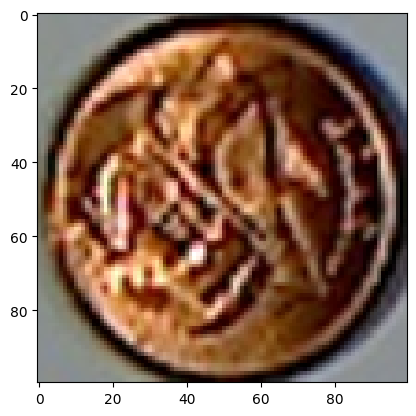

In [8]:

import matplotlib.pyplot as plt
import cv2
img = cv2.imread(r"/kaggle/working/imgs/test/cinco/5_1477290144.jpg", cv2.IMREAD_COLOR)
print(img.shape)
print(type(img))
plt.imshow(img)
arr, _ = extract_coins(img)
p = torch.from_numpy(arr[0])
print(p.shape)
plt.imshow(cv2.cvtColor(p.numpy(), cv2.COLOR_BGR2RGB))
tensor = torch.from_numpy(arr[0])
tensor/255.0

#### I am creating a custom dataset class that inherits methods from the torch Dataset. This CustomImageFolder class provides all the necessary functions for this project. <br>
#### I had to create a special method for this class, called delete_item. The reason for this is that some images could not be processed by the transform class I created. Further in the code, you will see the utility of this method.

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
class CustomImageFolder(Dataset):

    def __init__(self, root, transform=None):
        self.count = 0
        self.dataset = datasets.ImageFolder(root, transform=transform)
        self.valid_indices = list(range(len(self.dataset))) 
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
    def __len__(self):
        return len(self.valid_indices) - self.count

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        return self.dataset[actual_idx]

    def delete_item(self, idx):
        actual_idx = self.valid_indices[idx]
        self.valid_indices.remove(actual_idx)
        self.count = self.count + 1


#### Creating the train, validation and test dataset and applying the extract_coin and changing the brightness, contrast and saturation of the images

In [10]:
exform = transforms.Compose([
    
    ExtractCoinsTransform(to_size=100, min_radius=10, max_radius=100),
    v2.ColorJitter(brightness=0.5,contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip()
])


trainds = CustomImageFolder(r"/kaggle/working/imgs/train", transform = exform)
testds = CustomImageFolder(r"/kaggle/working/imgs/test",transform = exform)
valds = CustomImageFolder(r"/kaggle/working/imgs/val", transform = exform)



#### Creating a function clearvals to make the process of deleting the images that no coins were found faster <br><br> Since the shape of the first image of the train dataset is correct and i know that the shapes of the images tha were not processed are different, i based my function that

In [11]:
def clearvals(x, shape):
    to_delete = []
    for i in range(len(x.dataset)):
        if x.dataset[i][0].shape != shape:
            print(i)
            to_delete.append(i)
    for i in reversed(to_delete):
        x.delete_item(i)
shape = trainds.dataset[0][0].shape
clearvals(trainds, shape)
clearvals(testds, shape)
clearvals(valds, shape)

no coins in the image
5
no coins in the image
7
no coins in the image
77
no coins in the image
309
no coins in the image
315
no coins in the image
988
no coins in the image
1222
no coins in the image
1354
no coins in the image
1654
no coins in the image
2204
no coins in the image
2205
no coins in the image
2279
no coins in the image
2309
no coins in the image
2310
no coins in the image
2317
no coins in the image
2442
no coins in the image
25
no coins in the image
274
no coins in the image
84
no coins in the image
237
no coins in the image
302


#### Loading the images into the loaders. loader1 for train, loader2 for test and loader3 for validation. 

In [12]:
loader1 = torch.utils.data.DataLoader(trainds, batch_size = 64,shuffle = True, num_workers = 1)
loader2 = torch.utils.data.DataLoader(testds, batch_size = 64,shuffle = False, num_workers = 1)
loader3 = torch.utils.data.DataLoader(valds, batch_size = 64,shuffle = False, num_workers = 1)    

#### Plotting a random image after the transformation of the Dataset

torch.Size([3, 100, 100])


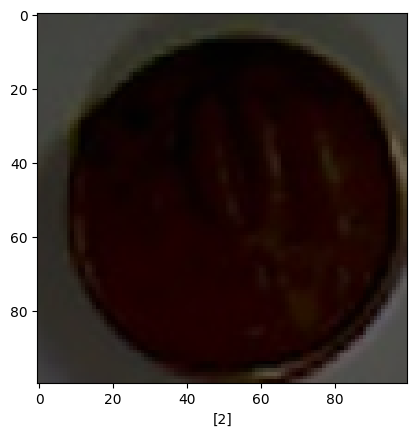

In [13]:
from matplotlib import pyplot as plt
import random
i = random.randint(0, 2000)

(v,label) = loader1.dataset[i][0], loader1.dataset[i][1]
#print(trainds)
print(v.shape)
v = v.numpy()
v =v.transpose(2,1,0)

label_str = str([label])
plt.xlabel(label_str)
#print(v)
plt.imshow(v)
plt.show()

#### Creating the Convolutional Neural Network architecture with 4 convolutional layers with batch normalization and ReLU activaction. <br><br> Max Pooling after the first 3 conv layers <br><br> Global average pooling after all the conv layers <br><br> 3 Fully connected layers. <br><br> Dropout before the final fully conected layer

In [14]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=5):
        super(CNN, self).__init__()
        
        self.conv1 = self._conv_bn_relu(in_channels, 32)
        self.conv2 = self._conv_bn_relu(32, 64)
        self.conv3 = self._conv_bn_relu(64, 128)
        self.conv4 = self._conv_bn_relu(128, 256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), 3, 100, 100)
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.global_avg_pool(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def _conv_bn_relu(self, in_channels, out_channels, kernel_size=3, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

vr = torch.randn(64, 3, 100, 100)
model = CNN()
lrate = 0.001
print(model(vr).shape)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lrate)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)
print(device)

torch.Size([64, 5])
cuda


#### Creating the train and validate function


In [15]:
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
def train(model, train_loader, validation_loader, device,
          loss_fn, optimizer, num_epochs, patience=3):
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    epoch = 0
    best_val_loss = float('inf')
    best_model_weights = None
    early_stopping_counter = 0

    while epoch < num_epochs and early_stopping_counter < patience:
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(enumerate(train_loader), ncols=600, total=len(train_loader))
        for batch_idx, (inputs, labels) in pbar:
            pbar.set_description(f'Epoch {epoch+1}/{num_epochs} ')
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc, _ = evaluate(model, validation_loader, device, loss_fn)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        
        print(f'train_loss: {train_loss:.4f} | '
              f'train_acc: {train_acc:.4f} | ' +
              f'val_loss: {val_loss:.4f} | ' +
              f'val_acc: {val_acc:.4f}', '\n')

        if history['val_loss'][-1] < best_val_loss:
            best_model_weights = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        best_val_loss = history['val_loss'][-1]
        epoch += 1

    return history, best_model_weights
def evaluate(model, data_loader, device, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = total_loss / len(data_loader)
    val_acc = correct / total

    
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return val_loss, val_acc, f1


#### Training the model with 40 epochs and 5 rounds of patience

In [16]:
history, bestmodelw = train(model, loader1, loader3, device, criterion, optimizer, num_epochs = 40, patience = 5)

  0%|                                                                                                         …

train_loss: 1.1613 | train_acc: 0.5195 | val_loss: 1.3601 | val_acc: 0.4262 



  0%|                                                                                                         …

train_loss: 0.8797 | train_acc: 0.6421 | val_loss: 0.8409 | val_acc: 0.6611 



  0%|                                                                                                         …

train_loss: 0.7660 | train_acc: 0.6744 | val_loss: 0.8342 | val_acc: 0.6745 



  0%|                                                                                                         …

train_loss: 0.7001 | train_acc: 0.6893 | val_loss: 0.8433 | val_acc: 0.6779 



  0%|                                                                                                         …

train_loss: 0.6867 | train_acc: 0.6968 | val_loss: 1.1285 | val_acc: 0.6309 



  0%|                                                                                                         …

train_loss: 0.6507 | train_acc: 0.7104 | val_loss: 0.6917 | val_acc: 0.7114 



  0%|                                                                                                         …

train_loss: 0.6237 | train_acc: 0.7183 | val_loss: 0.6122 | val_acc: 0.7383 



  0%|                                                                                                         …

train_loss: 0.5461 | train_acc: 0.7411 | val_loss: 0.5884 | val_acc: 0.7550 



  0%|                                                                                                         …

train_loss: 0.5692 | train_acc: 0.7382 | val_loss: 0.7610 | val_acc: 0.6510 



  0%|                                                                                                         …

train_loss: 0.5308 | train_acc: 0.7635 | val_loss: 0.6971 | val_acc: 0.7450 



  0%|                                                                                                         …

train_loss: 0.5036 | train_acc: 0.7821 | val_loss: 0.5876 | val_acc: 0.7852 



  0%|                                                                                                         …

train_loss: 0.5113 | train_acc: 0.7771 | val_loss: 1.0557 | val_acc: 0.6074 



  0%|                                                                                                         …

train_loss: 0.4991 | train_acc: 0.7829 | val_loss: 0.9404 | val_acc: 0.6946 



  0%|                                                                                                         …

train_loss: 0.4643 | train_acc: 0.8074 | val_loss: 1.6028 | val_acc: 0.5034 



  0%|                                                                                                         …

train_loss: 0.5066 | train_acc: 0.7920 | val_loss: 0.5356 | val_acc: 0.8289 



  0%|                                                                                                         …

train_loss: 0.4324 | train_acc: 0.8273 | val_loss: 0.5182 | val_acc: 0.7886 



  0%|                                                                                                         …

train_loss: 0.5073 | train_acc: 0.7949 | val_loss: 0.6543 | val_acc: 0.7517 



  0%|                                                                                                         …

train_loss: 0.4567 | train_acc: 0.8277 | val_loss: 0.4265 | val_acc: 0.8322 



  0%|                                                                                                         …

train_loss: 0.3837 | train_acc: 0.8612 | val_loss: 0.3589 | val_acc: 0.8758 



  0%|                                                                                                         …

train_loss: 0.3989 | train_acc: 0.8434 | val_loss: 0.4382 | val_acc: 0.8154 



  0%|                                                                                                         …

train_loss: 0.3879 | train_acc: 0.8641 | val_loss: 0.5541 | val_acc: 0.7718 



  0%|                                                                                                         …

train_loss: 0.3791 | train_acc: 0.8770 | val_loss: 0.4265 | val_acc: 0.8423 



  0%|                                                                                                         …

train_loss: 0.3394 | train_acc: 0.8865 | val_loss: 0.5677 | val_acc: 0.8087 



  0%|                                                                                                         …

train_loss: 0.3363 | train_acc: 0.8877 | val_loss: 0.9884 | val_acc: 0.6611 



  0%|                                                                                                         …

train_loss: 0.3479 | train_acc: 0.8832 | val_loss: 0.5110 | val_acc: 0.8423 



  0%|                                                                                                         …

train_loss: 0.3241 | train_acc: 0.8944 | val_loss: 0.2962 | val_acc: 0.9128 



  0%|                                                                                                         …

train_loss: 0.2777 | train_acc: 0.9047 | val_loss: 1.0635 | val_acc: 0.6544 



  0%|                                                                                                         …

train_loss: 0.3051 | train_acc: 0.8940 | val_loss: 0.3066 | val_acc: 0.8960 



  0%|                                                                                                         …

train_loss: 0.2753 | train_acc: 0.9126 | val_loss: 0.4235 | val_acc: 0.8490 



  0%|                                                                                                         …

train_loss: 0.2495 | train_acc: 0.9138 | val_loss: 0.2536 | val_acc: 0.9228 



  0%|                                                                                                         …

train_loss: 0.2646 | train_acc: 0.9138 | val_loss: 0.5534 | val_acc: 0.8188 



  0%|                                                                                                         …

train_loss: 0.3022 | train_acc: 0.8973 | val_loss: 1.6943 | val_acc: 0.5772 



  0%|                                                                                                         …

train_loss: 0.2818 | train_acc: 0.9076 | val_loss: 0.4393 | val_acc: 0.8456 



  0%|                                                                                                         …

train_loss: 0.2189 | train_acc: 0.9304 | val_loss: 0.5220 | val_acc: 0.8255 



  0%|                                                                                                         …

train_loss: 0.2644 | train_acc: 0.9122 | val_loss: 0.6285 | val_acc: 0.8255 



  0%|                                                                                                         …

train_loss: 0.2500 | train_acc: 0.9188 | val_loss: 0.4171 | val_acc: 0.8557 



  0%|                                                                                                         …

train_loss: 0.2236 | train_acc: 0.9267 | val_loss: 0.9703 | val_acc: 0.7047 



  0%|                                                                                                         …

train_loss: 0.2110 | train_acc: 0.9300 | val_loss: 0.3726 | val_acc: 0.8725 



  0%|                                                                                                         …

train_loss: 0.2175 | train_acc: 0.9300 | val_loss: 0.2892 | val_acc: 0.8993 



  0%|                                                                                                         …

train_loss: 0.2104 | train_acc: 0.9354 | val_loss: 0.6295 | val_acc: 0.8691 



#### Saving the model locally

In [17]:
checkpoint = {'model': CNN(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

### Accuracy, loss and F1_Score for the test set


In [18]:
t_loss,t_acc, test_f1 = evaluate(model, loader2 ,device, criterion)
print(f"test accuracy: {t_acc* 100:.4f} %")
print(f"test loss: {t_loss:.4f} test F1: {test_f1:.4f}")

test accuracy: 90.4918 %
test loss: 0.4159 test F1: 0.9026


#### Creating the functions im going to be using for plotting the results of the model for each epoch and for the confusion matrix


In [19]:
def plot_comparision_result(model):
   
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    
    axs[0].plot(model['history']['train_acc'], color="red", marker="o")
    axs[0].plot(model['history']['val_acc'], color="blue", marker="h")
    axs[0].set_title('Accuracy Comparison between Train & Validation Set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc="lower right")
    
   
    axs[1].plot(model['history']['train_loss'], color="red", marker="o")
    axs[1].plot(model['history']['val_loss'], color="blue", marker="h")
    axs[1].set_title('Loss Comparison between Train & Validation Set')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc="upper right")

    plt.tight_layout()
    plt.show()




def get_ture_and_pred_labels(dataloader, model):
   
    i = 0
    y_true = []
    y_pred = []
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred



def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

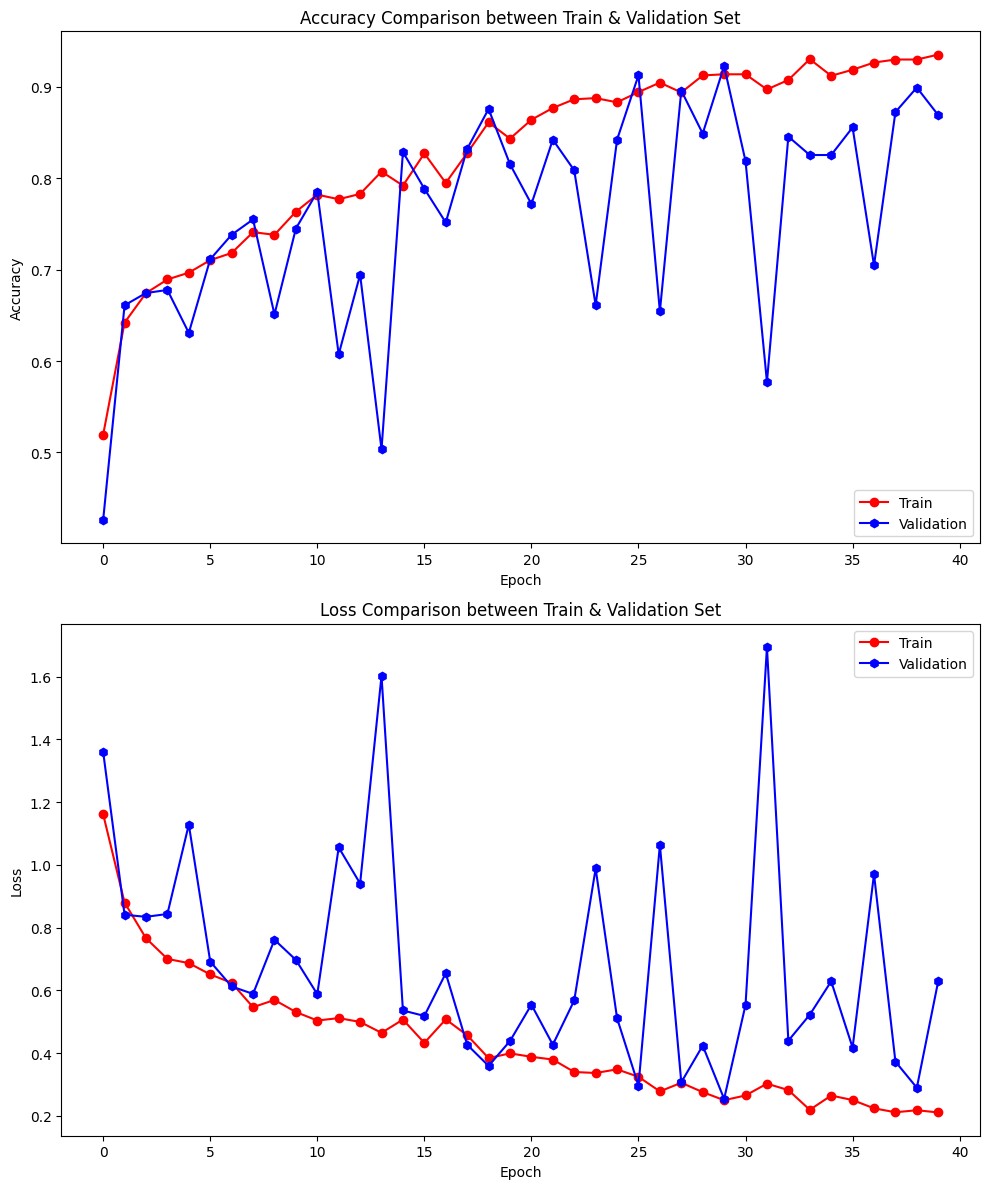

In [20]:
size_histories = {}
size_histories['Model'] = {'history':history, 'weights':bestmodelw}
plot_comparision_result(size_histories['Model'])

#### Below here you can see how many times the model got the wrong label for each image on the test set on the confusion matrix, and the classification report for each label



              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93        59
         1.0       0.98      0.89      0.94        65
         2.0       0.98      0.97      0.98        61
         3.0       0.78      1.00      0.87        62
         4.0       1.00      0.69      0.82        58

    accuracy                           0.91       305
   macro avg       0.92      0.91      0.91       305
weighted avg       0.92      0.91      0.91       305
 




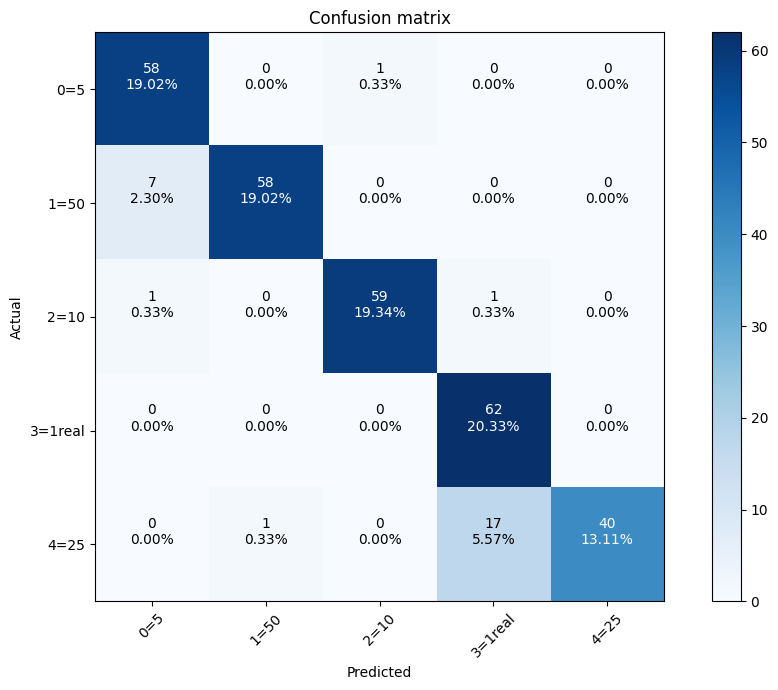

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
y_true, y_pred = get_ture_and_pred_labels(loader2, model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

classes = {
    "5":0,
    "50":1,
    "10":2,
    "1real":3,
    "25":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Plotting 4 random images on the test set to virtually see how the model works

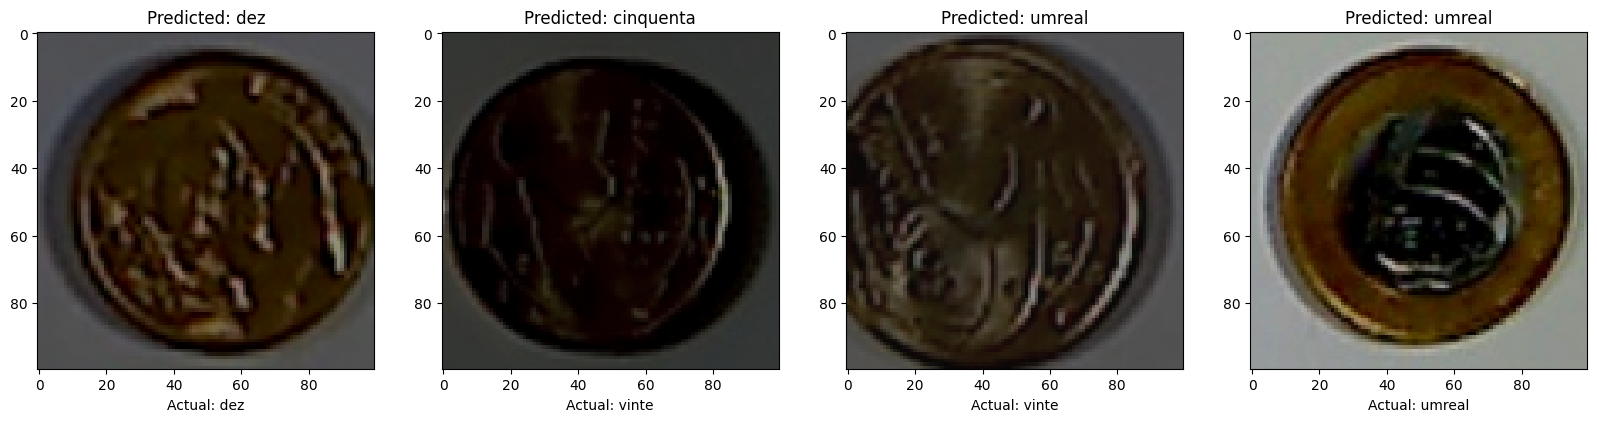

In [56]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  

for i in range(4):
    idx = random.randint(100, 320)
    image, label = loader2.dataset[idx]

    image = image.unsqueeze(0).to(device)
    output = model(image)

    classes = loader2.dataset.classes
    _, predicted = torch.max(output, 1)
    predicted_class = classes[predicted.item()]

    v = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    class_to_idx = loader2.dataset.class_to_idx
    idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

    axs[i].set_xlabel(f'Actual: {idx_to_class[label]}')  
    axs[i].set_title(f'Predicted: {predicted_class}')
    axs[i].imshow(v)

plt.show()
